## NOTES:
<ul>
<li>This notebook allows for further analysis of a single site and single metric from the dataset produced by aquifer analysis</li>
<li>The purpose is primarily for data visualization as well as deeper exploration into sites of interest. It is also for data validation. Additionally, this notebook gives more insight into what each metric is measuring and what each column of the aquifer analysis data sets represent</li><br>
<li>Each metric can be run independently of any others and are calculated using the same methods as in the aquifer analysis</li>
<li>As such, each metric is calculated independently here rather than relying on any data from any previous cells to ensure reliability</li>
<li>Furthermore, each visual is produced using the raw data, rather than the results of the calculations so that conclusions can be drawn on whether or not the visualization matches with the calculations</li>
</ul>

## CORE: Imports and Controls

In [1]:
# Imports -- Python 3.10
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

from matplotlib import ticker
from importlib import reload
from dataretrieval import nwis
from datetime import timedelta

# Custom libs
import Src.func as fn
import Src.classes as cl
reload(fn)
reload(cl)

pd.options.mode.chained_assignment = None

c:\Users\alekh\AppData\Local\Programs\Python\Python310\lib\site-packages\dataretrieval\nadp.py:44: UserWarning: GDAL not installed. Some functions will not work.
  warnings.warn('GDAL not installed. Some functions will not work.')


In [2]:
# Controls
# '11447650' -- SRB
site_no = '01578310'

K_DEFAULT_START = '1900-10-01'
K_DEFAULT_END = '2014-09-30' # end date for Kocis paper

DEFAULT_START = '1900-10-01'
DEFAULT_END = '2020-09-30' # end date for this study
df = nwis.get_record(sites=site_no, service=fn.SERVICE, parameterCD=[fn.PARAM_CODE, fn.TIDAL_CODE], start=DEFAULT_START, end=DEFAULT_END)
df = fn.merge_tidal(df)

# Aquifer analysis is done on both 30 and 50-year periods with both 90 and 95% quantiles
data_range = 30 
quantile = 0.90

## METRIC: Valid
The `valid` column indicates whether a given site is missing no more than `MAX_MISSING_THRESHOLD` percent of its data across the analyzed range. For the purposes of this study `MAX_MISSING_THRESHOLD` is set to 10%.

Columns: Index(['datetime', '00060_Mean', 'site_no'], dtype='object')
Valid: True -- Missing 0.0000%


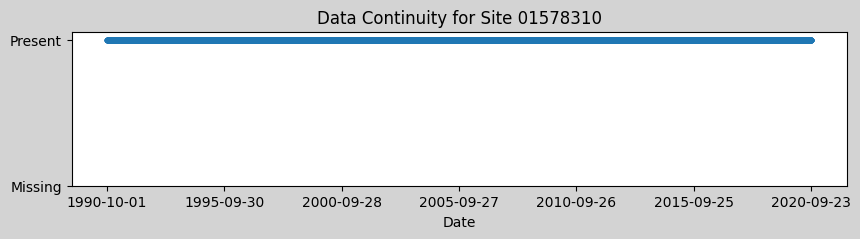

In [3]:
df_valid = df.reset_index()
print(f'Columns: {df_valid.columns}')

# Trim the dataset to just the current analyzed date range (end date - data_range)
# Set all present values to 1
start = pd.to_datetime(DEFAULT_END).date() - timedelta(days=365.25 * data_range)
df_valid = df_valid[df_valid['datetime'].dt.date >= start]
df_valid['00060_Mean'] = 1 

# Validation using the predetermined start and end dates of (1970/90-2020)
missing = fn.validate(df_valid, start, DEFAULT_END)
print(f"Valid: {missing < fn.MAX_MISSING_THRESHOLD} -- Missing {missing * 100:.4f}%")

# Create missing dates and set their values to 0
complete_range = pd.date_range(start=start, end=DEFAULT_END, freq='D')
df_complete = pd.DataFrame({'datetime': complete_range})
df_valid = pd.concat([df_complete.set_index('datetime').tz_localize(None), df_valid.set_index('datetime').tz_localize(None)], axis=1, join='outer').fillna(0).reset_index()

plt.figure(figsize=(10, 2), facecolor='lightgray')
plt.plot(df_valid['datetime'], df_valid['00060_Mean'], marker='.', linestyle='dotted')

plt.yticks([0, 1], ['Missing', 'Present'])
plt.xticks(df_valid['datetime'][::(365*5)])
plt.xlabel("Date")

plt.title(f"Data Continuity for Site {site_no}")
plt.show()

## METRIC: Threshold
The `threshold` value is the flow value (ft<sup>3</sup>/s) above which any excess flow is considered high magnitude flow (HMF). This value is calculated as some quantile, 90% and 95% in the case of this study, of the total streamflow.

Threshold: 85700.0


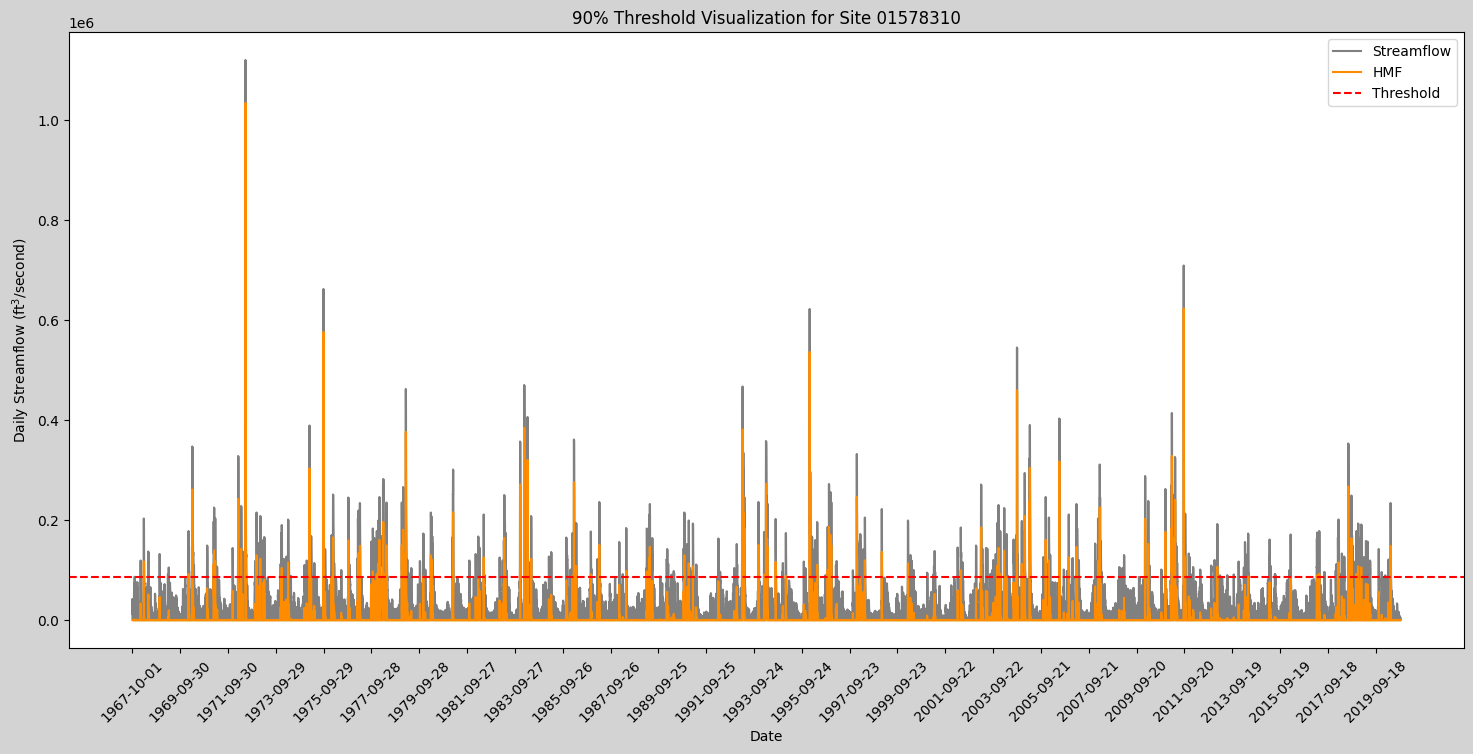

In [4]:
df_threshold = df.reset_index()

#start = pd.to_datetime(fn.DEFAULT_END).date() - timedelta(days=365.25 * data_range)
#df_threshold = df_threshold[df_threshold['datetime'].dt.date >= start]


threshold = fn.calc_threshold(df_threshold, quantile)
print(f"Threshold: {threshold}")

df_threshold["diff"] = df_threshold["00060_Mean"] - threshold
df_threshold["hmf"] = df_threshold["diff"].apply(lambda x: max(0, x))

'''window = 50
df_threshold["00060_Mean"] = df_threshold["00060_Mean"].rolling(window=window).mean()
df_threshold["hmf"] = df_threshold["hmf"].rolling(window=window).mean()'''

plt.figure(figsize=(18, 8), facecolor='lightgray')
plt.plot(df_threshold["datetime"], df_threshold["00060_Mean"], label="Streamflow", color="gray")
plt.plot(df_threshold["datetime"], df_threshold["hmf"], label="HMF", color="darkorange")
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')

plt.fill_between(df_threshold["datetime"], df_threshold["00060_Mean"], color="gray")
plt.fill_between(df_threshold["datetime"], df_threshold["hmf"], color="orange")

plt.xticks(df_threshold['datetime'][::(365*2)], rotation=45)
plt.xlabel("Date")

plt.ylabel('Daily Streamflow ($\mathregular{ft^3}$/second)')

plt.title(f"{quantile*100:.0f}% Threshold Visualization for Site {site_no}")
plt.legend()
plt.show()

## METRIC: HMF Years, Inter-Annual Frequency
The `hmf_years` column tracks the total number of hydrologic years over the analyzed range that saw any amount of HMF. `inter_annual` tracks the frequency with which years experience at least one HMF event.

HMF Years: 30
Inter-Annual: 1.0
Delta 30, 30
Min: 1990 Max: 2019


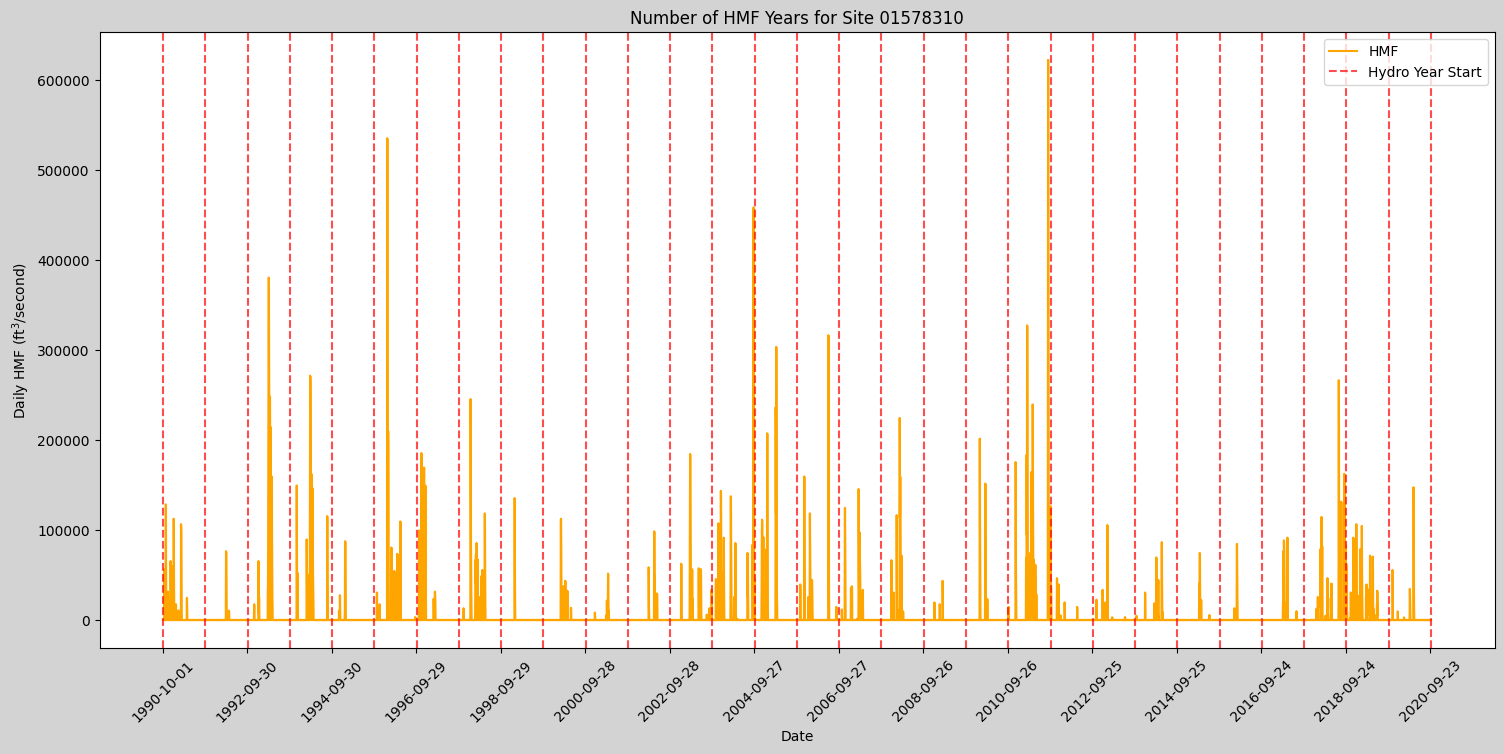

In [5]:
df_threshold = df.reset_index()

start = pd.to_datetime(fn.DEFAULT_END).date() - timedelta(days=365.25 * data_range)
df_threshold = df_threshold[df_threshold['datetime'].dt.date >= start]

threshold = fn.calc_threshold(df_threshold, quantile)
hmf_series_defl, hmf_series_cont = fn.filter_hmf(df_threshold, threshold)
hmf_years = fn.num_hmf_years(hmf_series_defl)
print(f"HMF Years: {hmf_years}")

hmf_series_cont['datetime'] = hmf_series_cont['datetime'] + pd.DateOffset(months=-9)
delta = hmf_series_cont["datetime"].dt.year.nunique()
print(f"Inter-Annual: {hmf_years / delta}")
print(f'Delta {math.ceil(delta)}, {delta}')
print(f'Min: {hmf_series_cont["datetime"].min().year} Max: {hmf_series_cont["datetime"].max().year}')

df_threshold["diff"] = df_threshold["00060_Mean"] - threshold
df_threshold["hmf"] = df_threshold["diff"].apply(lambda x: max(0, x))

plt.figure(figsize=(18, 8), facecolor='lightgray')
plt.plot(df_threshold["datetime"], df_threshold["hmf"], label="HMF", color="orange")

first = True
for year in range(df_threshold["datetime"].dt.year.min(), df_threshold["datetime"].dt.year.max() + 1):
    oct1 = pd.to_datetime(f'{year}-10-01')

    if first:
        plt.axvline(oct1, color='red', linestyle='--', alpha=0.7, label='Hydro Year Start')
        first = False
    else:
        plt.axvline(oct1, color='red', linestyle='--', alpha=0.7)        

plt.fill_between(df_threshold["datetime"], df_threshold["hmf"], color="orange")

plt.xticks(df_threshold['datetime'][::(365*2)], rotation=45)
plt.xlabel("Date")

plt.ylabel('Daily HMF ($\mathregular{ft^3}$/second)')

plt.title(f"Number of HMF Years for Site {site_no}")
plt.legend()
plt.show()



## METRIC: Annual HMF
The `annual_hmf` column holds the average amount of HMF, in km<sup>3</sup> per year.

Annual HMF: 5.02 km^3/year


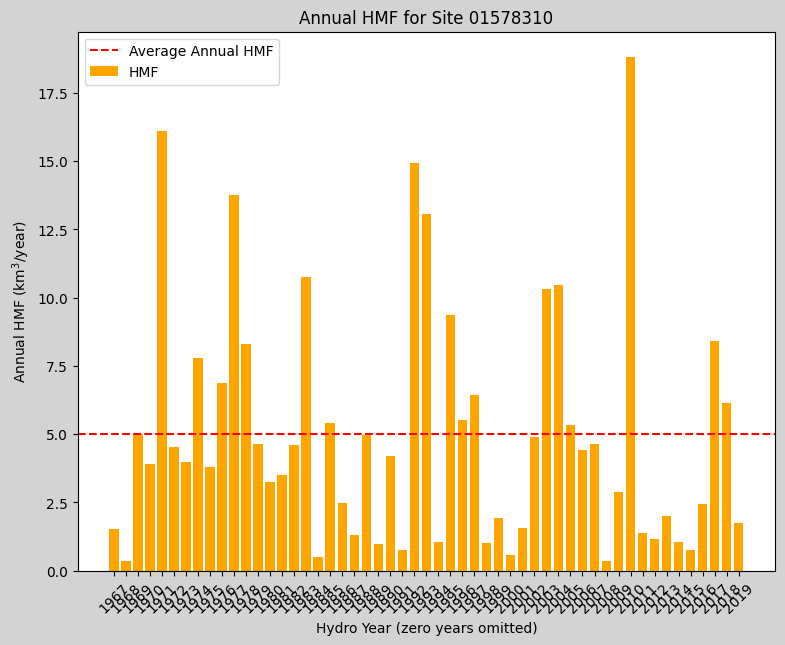

In [6]:
df_annualhmf = df.reset_index()

#start = pd.to_datetime(fn.DEFAULT_END).date() - timedelta(days=365.25 * data_range)
#df_annualhmf = df_annualhmf[df_annualhmf['datetime'].dt.date >= start]

threshold = fn.calc_threshold(df_annualhmf, quantile)
hmf_series, _ = fn.filter_hmf(df_annualhmf, threshold)
hmf_years = fn.num_hmf_years(hmf_series)
hmf_series = fn.convert_hmf(hmf_series, threshold)

hmf_series = hmf_series.reset_index()
hmf_series['datetime'] = pd.to_datetime(hmf_series['datetime'])
hmf_series.set_index('datetime', inplace=True)

annual_sum = hmf_series['00060_Mean'].resample(fn.HYDRO_YEAR).sum()
annual_sum = annual_sum * fn.CUBIC_FT_KM_FACTOR
annual_hmf = annual_sum.sum() / hmf_years
print(f"Annual HMF: {annual_hmf:.2f} km^3/year")

# Filtering out 0 years since average is calculated using only non-zero years
# and this will make the visualization more accurate
annual_sum = annual_sum[annual_sum > 0]

fig = plt.figure(figsize=(9, 7), facecolor='lightgray')
plt.bar(range(len(annual_sum.index)), annual_sum, color='orange')
plt.axhline(y=annual_hmf, color='r', linestyle='--')

plt.xlabel('Hydro Year (zero years omitted)')
plt.xticks(range(len(annual_sum.index)), annual_sum.index.strftime('%Y'), rotation=45)
plt.ylabel('Annual HMF ($\mathregular{km^3}$/year)')

plt.title(f'Annual HMF for Site {site_no}')
plt.legend(['Average Annual HMF', 'HMF'])
plt.show()


## METRIC: 3 and 6 Month HMF
The `three_mo_hmf` and `six_mo_hmf` columns indicate the HMF (in km<sup>3</sup>/year) over a selected 3-month and 6-month window of the wettest months of the hydrologic year. The default 3-month window is from Dec-Feb, while the 6-month window is Nov-Apr.

In [41]:
# Window selection by month
three_start = 12
three_end = 2
six_start = 11
six_end = 4

# Window to view for first plot (visualization is too busy with windows larger than one year)
window_start = pd.Timestamp('1994-10-01')
window_end = pd.Timestamp(window_start + pd.DateOffset(days=365))

In [ ]:
df_threesix = df.reset_index()

start = pd.to_datetime(fn.DEFAULT_END).date() - timedelta(days=365.25 * data_range)
df_threesix = df_threesix[df_threesix['datetime'].dt.date >= start]

threshold = fn.calc_threshold(df_threesix, quantile)
hmf_series, _ = fn.filter_hmf(df_threesix, threshold)
hmf_years = fn.num_hmf_years(hmf_series)

df_six_mo, df_three_mo = fn.three_six_range(hmf_series, three_start, three_end, six_start, six_end)

# For final report 
hmf_series = fn.convert_hmf(hmf_series, threshold)
hmf_series = hmf_series.reset_index(drop=True)
total_hmf_flow = (hmf_series["00060_Mean"].sum() * fn.CUBIC_FT_KM_FACTOR) / hmf_years

df_six_mo = fn.convert_hmf(df_six_mo, threshold)
df_six_mo = df_six_mo.reset_index(drop=True)
six_mo_hmf = (df_six_mo["00060_Mean"].sum() * fn.CUBIC_FT_KM_FACTOR) / hmf_years

df_three_mo = fn.convert_hmf(df_three_mo, threshold)
df_three_mo = df_three_mo.reset_index(drop=True) 
three_mo_hmf = (df_three_mo["00060_Mean"].sum() * fn.CUBIC_FT_KM_FACTOR) / hmf_years  

# Calculate the percentage of each HMF value compared to the total HMF flow
total_hmf_percentage = total_hmf_flow / total_hmf_flow * 100
six_mo_hmf_percentage = six_mo_hmf / total_hmf_flow * 100
three_mo_hmf_percentage = three_mo_hmf / total_hmf_flow * 100

print(f"6 Month HMF: {six_mo_hmf:.2f} -- {six_mo_hmf_percentage:.2f}% of Total HMF")
print(f"3 Month HMF: {three_mo_hmf:.2f} -- {three_mo_hmf_percentage:.2f}% of Total HMF")

# The following is all for plotting purposes and does not occur in Aquifer Analysis
# Fill missing datetime values with 0's for plotting
df_six_mo.drop(columns=['index'], inplace=True)
df_three_mo.drop(columns=['index'], inplace=True)
df_six_mo = df_six_mo.set_index('datetime').resample('D').asfreq().fillna(0).reset_index()
df_three_mo = df_three_mo.set_index('datetime').resample('D').asfreq().fillna(0).reset_index()

# Zero out any negative HMF values (days where streamflow is below threshold)
df_threesix["diff"] = df_threesix["00060_Mean"] - threshold
df_threesix["hmf"] = df_threesix["diff"].apply(lambda x: max(0, x))
df_six_mo["diff"] = df_six_mo["00060_Mean"] - threshold
df_six_mo["hmf"] = df_six_mo["diff"].apply(lambda x: max(0, x))
df_three_mo["diff"] = df_three_mo["00060_Mean"] - threshold
df_three_mo["hmf"] = df_three_mo["diff"].apply(lambda x: max(0, x))

fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True, facecolor='lightgray')

# Plot for total hmf
axes[0].plot(df_threesix["datetime"], df_threesix["hmf"], label="df_threesix", color="orange")
axes[0].fill_between(df_threesix["datetime"], df_threesix["hmf"], color="orange")
axes[0].set_ylabel('Daily HMF ($\mathregular{ft^3}$/second)')
axes[0].set_title(f'HMF for Site {site_no} During {window_start.year} Hydrological Year')
axes[0].set_xlim(window_start, window_end) 

# Plot for six month hmf
axes[1].plot(df_six_mo["datetime"], df_six_mo["hmf"], label="df_six_mo", color="lightcoral")
axes[1].fill_between(df_six_mo["datetime"], df_six_mo["hmf"], color="lightcoral")
axes[1].set_ylabel('Daily HMF ($\mathregular{ft^3}$/second)')
axes[1].set_title('Six Month HMF')
axes[0].set_xlim(window_start, window_end) 

# Plot for three month hmf
axes[2].plot(df_three_mo["datetime"], df_three_mo["hmf"], label="df_three_mo", color="orchid")
axes[2].fill_between(df_three_mo["datetime"], df_three_mo["hmf"], color="orchid")
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Daily HMF ($\mathregular{ft^3}$/second)')
axes[2].set_title('Three Month HMF')
axes[0].set_xlim(window_start, window_end) 

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6), facecolor='lightgray')
plt.bar(['Total HMF', 'Six Month HMF', 'Three Month HMF'], [total_hmf_flow, six_mo_hmf, three_mo_hmf], color=['orange', 'lightcoral', 'orchid'])

plt.axhline(y=six_mo_hmf, color='r', linestyle='--')
plt.axhline(y=three_mo_hmf, color='r', linestyle='--')

for i, v in enumerate([total_hmf_flow, six_mo_hmf, three_mo_hmf]):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')

plt.title(f'HMF Comparison for Site {site_no} Across Full Range')
plt.ylabel('Average Annual HMF ($\mathregular{km^3}$/year)')

plt.text(0, total_hmf_flow - 0.5, f'{total_hmf_percentage:.2f}%', ha='center')
plt.text(1, six_mo_hmf - 0.5, f'{six_mo_hmf_percentage:.2f}%', ha='center')
plt.text(2, three_mo_hmf - 0.5, f'{three_mo_hmf_percentage:.2f}%', ha='center')

plt.show()


## METRICS: Annual/Event Durations, Event HMF, and Intra-annual Frequency
The `average_duration` column measures the average number of days per HMF event per hydrologic year while the `event_duration` column reports the average number of days per HMF event. `event_hmf` is the average amount of HMF per event while the `intra-annual` column is the average number of events per year

In [6]:
df_duration = df.reset_index()
df_results = pd.DataFrame()

start = pd.to_datetime(fn.DEFAULT_END).date() - timedelta(days=365.25 * data_range)
df_duration = df_duration[df_duration['datetime'].dt.date >= start]
threshold = fn.calc_threshold(df_duration, quantile)
hmf_series_defl, hmf_series_cont = fn.filter_hmf(df_duration, threshold)
hmf_series_cont = fn.convert_hmf(hmf_series_cont, threshold)
hmf_years = fn.num_hmf_years(hmf_series_defl)

df_d = hmf_series_cont.reset_index()
df_d['datetime'] = df_d['datetime'] + pd.DateOffset(months=-9)
df_d['flow_bool'] = df_d['00060_Mean'].apply(lambda x: 1 if x > 0 else 0)


# Average HMF/year calculation
df_results = df_d.groupby(df_d["datetime"].dt.year)["00060_Mean"].sum().reset_index()
df_results["00060_Mean"] = df_results["00060_Mean"] * fn.CUBIC_FT_KM_FACTOR

# Total days per year calculation
df_results["total_days"] = df_d.groupby(df_d["datetime"].dt.year)["flow_bool"].sum().reset_index()["flow_bool"]

# Total events per year calculation
# Insert a day at the very beginning of the dataframe with flow_bool == 0 so that the first event is counted via diff()
first = df_d['datetime'].iloc[0] - timedelta(days=1)
insert = {'datetime': first, '00060_Mean': 0,  '00060_Mean_cd': None, 'site_no': None, 'flow_bool': 0}
df_d = pd.concat([pd.DataFrame(insert, index=[0]), df_d]).reset_index(drop=True)
df_d['Year'] = df_d['datetime'].dt.year
df_d['Change'] = df_d['flow_bool'].diff()
df_d['Year_Change'] = df_d['Year'].diff()

# Edgecase where flow carries over from previous year
df_d.loc[((df_d['Year_Change'] > 0) & (df_d['flow_bool'] == 1)), 'Change'] = 1

'''# Set Change == 1 if the first day of the year has an event to account for events spanning the new year
year_start_mask = (df_d['datetime'].dt.month == 1) & (df_d['datetime'].dt.day == 1)
df_d.loc[year_start_mask & (df_d['flow_bool'] == 1), 'Change'] = 1'''

series_continuous_sets = df_d[(df_d['Change'] == 1) & (df_d['flow_bool'] == 1)].groupby('Year').size()
series_continuous_sets = series_continuous_sets.reset_index()
series_continuous_sets.columns = ['Year', 'total_events']
df_results.rename(columns={'datetime': 'Year'}, inplace=True)
df_results = pd.merge(df_results, series_continuous_sets, on='Year', how='left')
df_results = df_results.fillna(0)

# Event HMF
df_results['event_hmf'] = df_results['00060_Mean'] / df_results['total_events']

# Event Duration
df_results['duration'] = df_results['total_days'] / df_results['total_events']

df_results = df_results.fillna(0)
annual_duration = df_results['total_days'].sum() / hmf_years    
event_duration = df_results['duration'].sum() / hmf_years
intra_annual = df_results['total_events'].sum() / hmf_years
event_hmf = df_results['event_hmf'].sum() / hmf_years

print(f'Annual Duration: {annual_duration:.2f} days')
print(f"Event Duration: {event_duration:.2f} days")
print(f"Intra-Annual: {intra_annual:.2f} events")
print(f'Event HMF: {event_hmf:.5f} km^3/year')
print(df_results)
#df_results.to_csv('event_duration.csv')

Annual Duration: 54.60 days
Event Duration: 20.76 days
Intra-Annual: 2.70 events
Event HMF: 1.03373 km^3/year
    Year  00060_Mean  total_days  total_events  event_hmf   duration
0   1990    0.000000           0           0.0   0.000000   0.000000
1   1991    0.000000           0           0.0   0.000000   0.000000
2   1992    2.242286          51           4.0   0.560572  12.750000
3   1993    0.000000           0           0.0   0.000000   0.000000
4   1994    6.569300         111           4.0   1.642325  27.750000
5   1995    3.282815          68           2.0   1.641408  34.000000
6   1996    5.009119          68           1.0   5.009119  68.000000
7   1997    5.812574         129           5.0   1.162515  25.800000
8   1998    2.876439          65           3.0   0.958813  21.666667
9   1999    2.283634          40           2.0   1.141817  20.000000
10  2000    0.000000           0           0.0   0.000000   0.000000
11  2001    0.268634          10           1.0   0.268634  10.

## METRIC: Timing
The `timing` column reports the average day in the hydrologic year that HMF reaches the halfway point of it's annual amount (the center of mass)

In [14]:
df_timing = df.reset_index()
start = pd.to_datetime(fn.DEFAULT_END).date() - timedelta(days=365.25 * data_range)
df_timing = df_timing[df_timing['datetime'].dt.date >= start]

threshold = fn.calc_threshold(df_timing, quantile)
hmf_series_defl, _ = fn.filter_hmf(df_timing, threshold)
hmf_series_defl = fn.convert_hmf(hmf_series_defl, threshold)

#print(hmf_series_defl)

df_t = hmf_series_defl.reset_index(drop=True)
df_t['datetime'] = df_t['datetime'] + pd.DateOffset(months=-9)

df_t['year'] = df_t['datetime'].dt.year
df_t['day'] = df_t['datetime'].dt.dayofyear
df_t['cumsum'] = df_t.groupby('year')['00060_Mean'].cumsum()
df_t['t_sum'] = df_t.groupby('year')['00060_Mean'].transform('sum')

com_series = df_t[df_t['cumsum'] >= df_t['t_sum'] / 2].groupby('year')['day'].first()
print(f'Timing: {com_series.mean()}')
print(com_series)


Timing: 190.48
year
1990    233
1992    215
1994    166
1995    137
1996    179
1997    241
1998    179
1999    196
2000    210
2001    195
2002    167
2005    196
2006    164
2007    238
2008    217
2009    249
2010    234
2011    185
2012     64
2013    161
2014    130
2016    174
2017    211
2018    190
2019    231
Name: day, dtype: int32


## SCRIPT: Tidally Filtered Data Merging Validation
Meta-analysis on tidally filtered sites

In [102]:
# Tidal sites meta-analysis
df_result = pd.DataFrame()

for i, site in enumerate(fn.TIDAL_SITES):
    #if i > 10: break
    print(f"Processing site {i + 1} of {len(fn.TIDAL_SITES)}")
    df_stream = nwis.get_record(sites=site, service=fn.SERVICE, parameterCD=fn.PARAM_CODE, start=fn.DEFAULT_START, end=fn.DEFAULT_END)
    df_tidal = nwis.get_record(sites=site, service=fn.SERVICE, parameterCD=fn.TIDAL_CODE, start=fn.DEFAULT_START, end=fn.DEFAULT_END)
    df_stream = df_stream.reset_index()
    df_tidal = df_tidal.reset_index()
    
    stream_data = not df_stream.empty
    tidal_data = not df_tidal.empty
    
    try:
        stream_start = df_stream['datetime'].dt.date.min()
        stream_end = df_stream['datetime'].dt.date.max()
    except:
        stream_start = "NA"
        stream_end = "NA"
        
    try:   
        tidal_start = df_tidal['datetime'].dt.date.min()
        tidal_end = df_tidal['datetime'].dt.date.max()
    except:
        tidal_start = "NA"
        tidal_end = "NA"
    
    data = {'site_no': str(site), 'stream_data': stream_data, 'tidal_data': tidal_data, 'stream_start': stream_start, 'stream_end': stream_end, 'tidal_start': tidal_start, 'tidal_end': tidal_end}
    df_result = pd.concat([df_result, pd.DataFrame(data, index=[0])], ignore_index=True)
    
df_result.to_excel('tidal_sites_analysis.xlsx')
    

Processing site 1 of 99
Processing site 2 of 99
Processing site 3 of 99
Processing site 4 of 99
Processing site 5 of 99
Processing site 6 of 99
Processing site 7 of 99
Processing site 8 of 99
Processing site 9 of 99
Processing site 10 of 99
Processing site 11 of 99
Processing site 12 of 99
Processing site 13 of 99
Processing site 14 of 99
Processing site 15 of 99
Processing site 16 of 99
Processing site 17 of 99
Processing site 18 of 99
Processing site 19 of 99
Processing site 20 of 99
Processing site 21 of 99
Processing site 22 of 99
Processing site 23 of 99
Processing site 24 of 99
Processing site 25 of 99
Processing site 26 of 99
Processing site 27 of 99
Processing site 28 of 99
Processing site 29 of 99
Processing site 30 of 99
Processing site 31 of 99
Processing site 32 of 99
Processing site 33 of 99
Processing site 34 of 99
Processing site 35 of 99
Processing site 36 of 99
Processing site 37 of 99
Processing site 38 of 99
Processing site 39 of 99
Processing site 40 of 99
Processin

In [12]:
# 11447650
site_no = '11447650'
date_range = 30
df_stream = nwis.get_record(sites=site_no, service=fn.SERVICE, parameterCD=fn.PARAM_CODE, start=fn.DEFAULT_START, end=fn.DEFAULT_END)
df_tidal = nwis.get_record(sites=site_no, service=fn.SERVICE, parameterCD=fn.TIDAL_CODE, start=fn.DEFAULT_START, end=fn.DEFAULT_END)
df_combined = nwis.get_record(sites=site_no, service=fn.SERVICE, parameterCD=[fn.PARAM_CODE, fn.TIDAL_CODE], start=fn.DEFAULT_START, end=fn.DEFAULT_END)
#df_stream.to_csv('stream.csv')
#df_tidal.to_csv('tidal.csv')

# Tidal merging function
# If we have both stream and tidal data, merge them, prioritizing tidal data
# If we only have stream data because tidal data is empty, use it as is
# If we only have tidal data because stream data is empty, convert tidal data columns to stream columns
def create_dataframe(df_combined):
    keep_cols = ['datetime', '00060_Mean', 'site_no']
    
    # No data at all (dont'need this check in the actual function because it's performed afterwards within Nat'l metrics dataset creation)
    if df_combined.empty:
        return df_combined
    
    # If we have both stream and tidal data, merge them, prioritizing tidal data, and rename the column to '00060_Mean'
    if '72137_Mean' in df_combined.columns and '00060_Mean' in df_combined.columns:
        df_combined['00060_Mean'] = df_combined['72137_Mean'].combine_first(df_combined['00060_Mean'])
        df_combined = df_combined.drop(columns=[col for col in df_combined.columns if col not in keep_cols])
        return df_combined
    
    # If we only have stream data use it as is, drop any unnecessary columns
    if '00060_Mean' in df_combined.columns:
        df_combined = df_combined.drop(columns=[col for col in df_combined.columns if col not in keep_cols])
        return df_combined
    
    # If we only have tidal data we'll rename it to stream data and use it as is
    if '72137_Mean' in df_combined.columns:
        df_combined.rename(columns={'72137_Mean': '00060_Mean'}, inplace=True)
        df_combined = df_combined.drop(columns=[col for col in df_combined.columns if col not in keep_cols])
        return df_combined
    
    # Catch-all
    return df_combined
    
    
df_result = create_dataframe(df_combined)
#df_result.to_csv('combined.csv')
print(df_result.head())
print(df_result.tail())

                           00060_Mean   site_no
datetime                                       
2020-09-26 00:00:00+00:00     10700.0  11447650
2020-09-27 00:00:00+00:00     10700.0  11447650
2020-09-28 00:00:00+00:00     10700.0  11447650
2020-09-29 00:00:00+00:00     10500.0  11447650
2020-09-30 00:00:00+00:00     10600.0  11447650


## SCRIPT: HUC2/4/Aquifer Sorting Validation
The code below is used to check that the HUC2/4/Aquifer boundaries assigned to each water gauge via the script in aquifer_analysis.ipynb are correct

In [16]:
# Only need to run once, takes ~20s
huc2_shape = gpd.read_file('ShapeFiles/HUC2/_Master_HUC2/master_huc2.shp')
huc4_shape = gpd.read_file('ShapeFiles/HUC4/_Master_HUC4/master_huc4.shp')
aq_shape = gpd.read_file('ShapeFiles/Aquifers/_Master_Aquifer/master_aquifer.shp')

In [20]:
# HUC's to plot
#huc2_list = ['01']
#huc4_list = ['1702', '1706', '0103', '0207']
dataset = 'Prelim_Data/_National_Validity/National_Validity.xlsx'
df = pd.read_excel(dataset, dtype={'site_no': str, 'huc2_code': str, 'huc4_code': str})
#df, _ = fn.filter_by_valid(df)

Number of Sites: 288


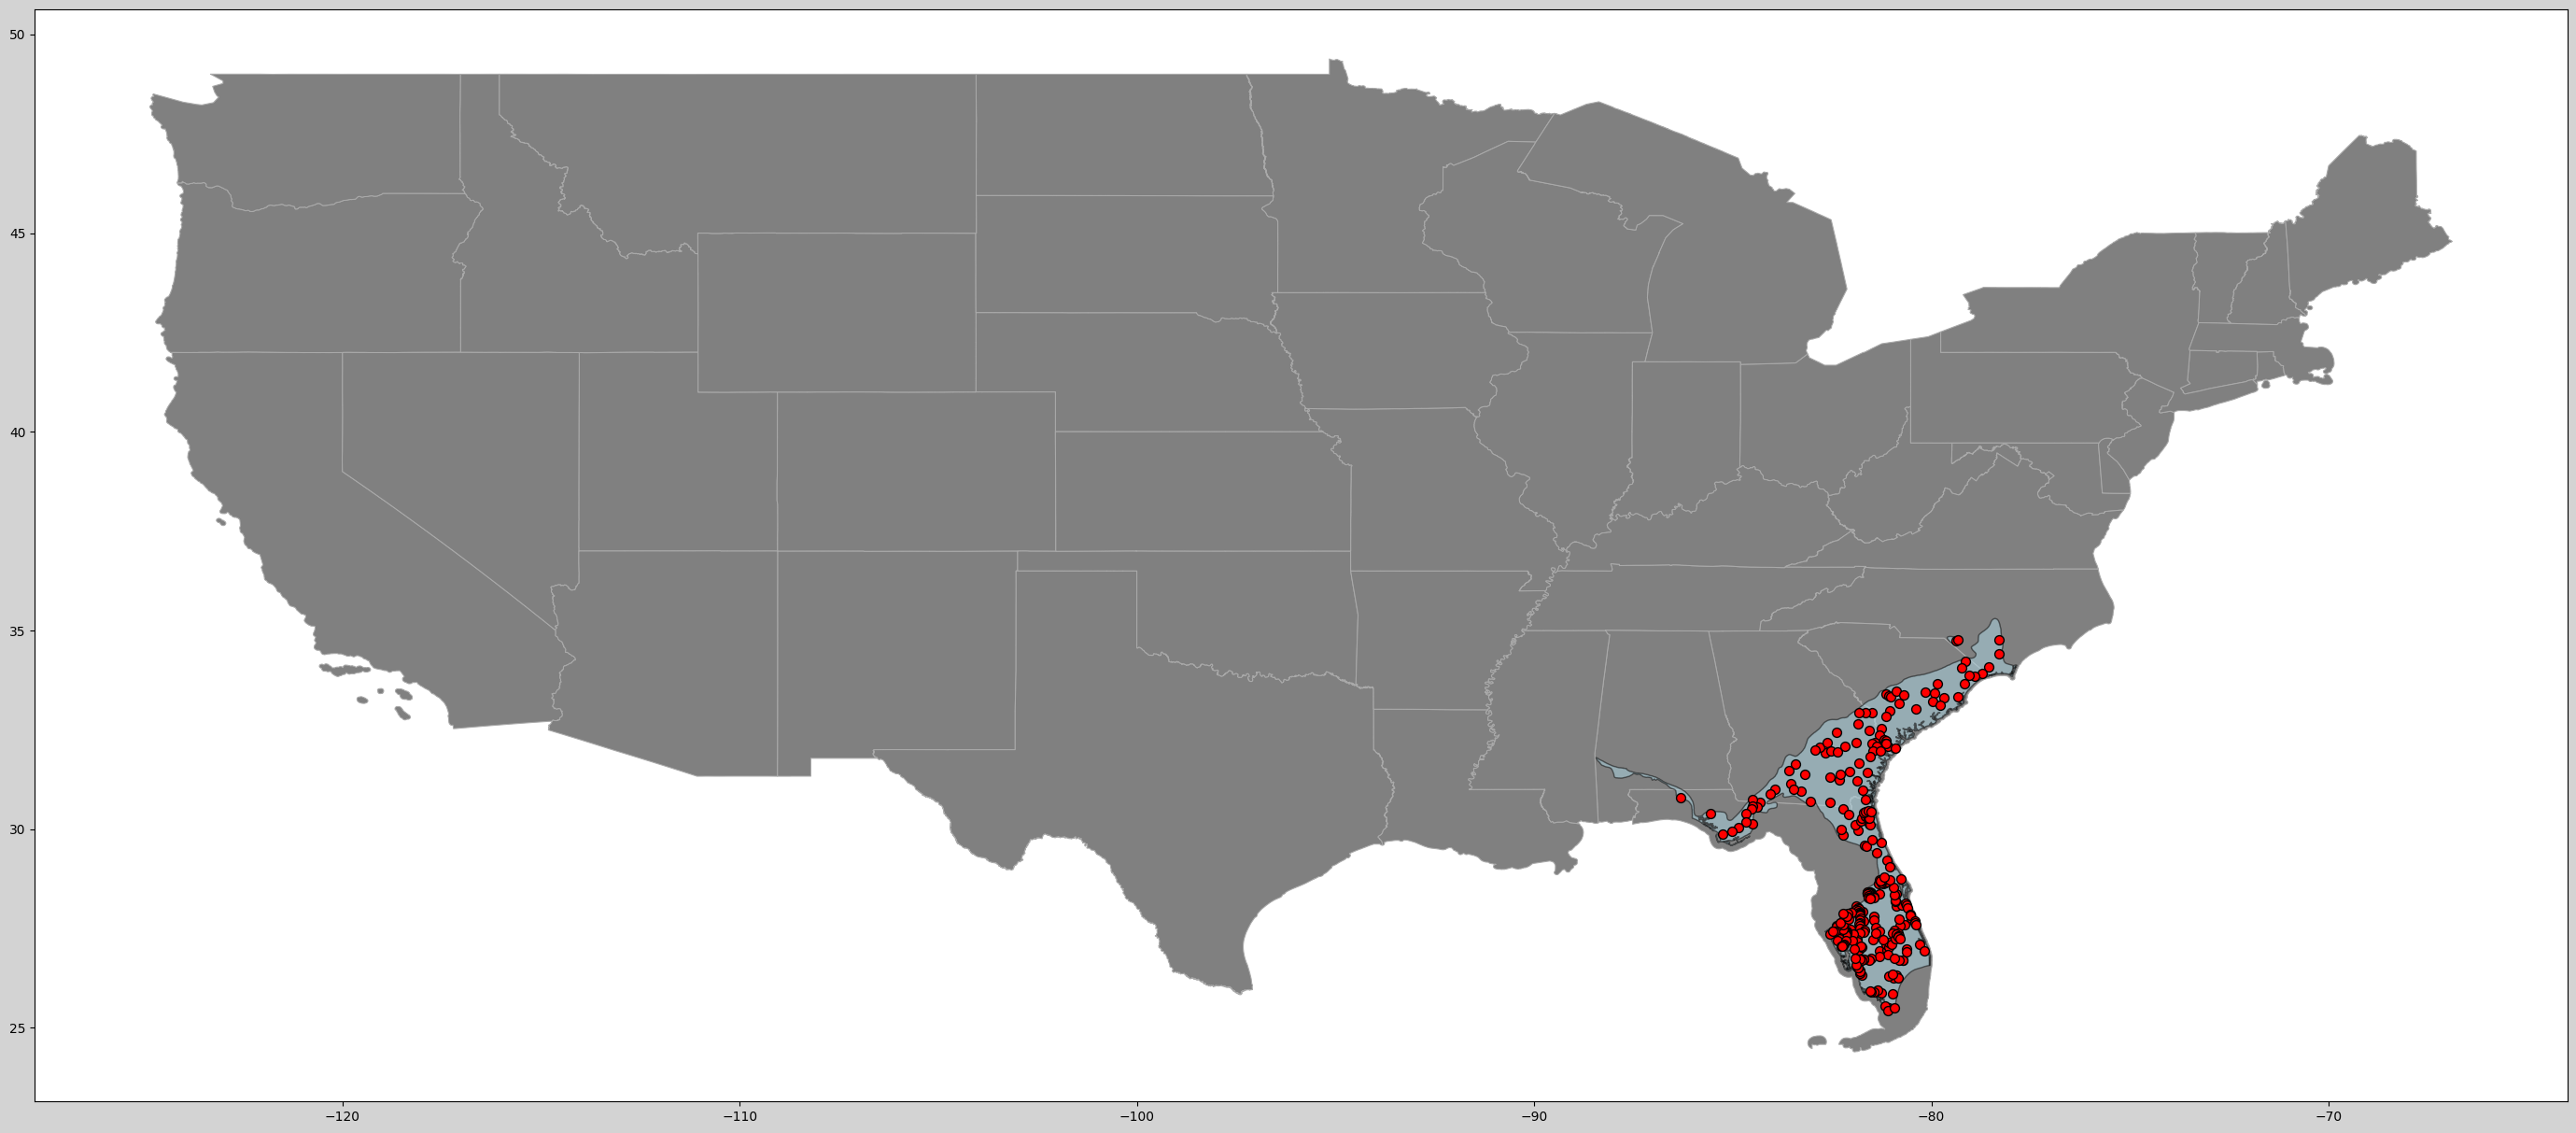

In [21]:
aquifer = 'Surficial aquifer system'

fig, ax = plt.subplots(figsize=(35, 35), facecolor='lightgray')
fn.plot_lower_48(ax)
#fn.plot_huc4(ax, shapefile=huc4_shape, codes=huc4_list)
#fn.plot_huc2(ax, codes=huc2_list)

aq_gdf = aq_shape[aq_shape['aq_name'] == aquifer]
aq_gdf.plot(ax=ax, color='lightblue', edgecolor='black', linewidth=1.0, alpha=0.5)
df_temp = df[df['aquifer'] == aquifer]
print(f"Number of Sites: {len(df_temp)}")
geo_df = fn.convert_geometry(df_temp)

geo_df.plot(ax=ax, color='red', edgecolor='black', markersize=50, alpha=1.0)
plt.show()

## SCRIPT: Master HUC2/HUC4/Aquifer Shapefile Validation
This code is for visually confirming that all HUC2s/HUC4s/Aquifers are included in their respective shapefiles

In [2]:
shapefile = gpd.read_file('ShapeFiles/Aquifers/_Master_Aquifer/master_aquifer.shp')

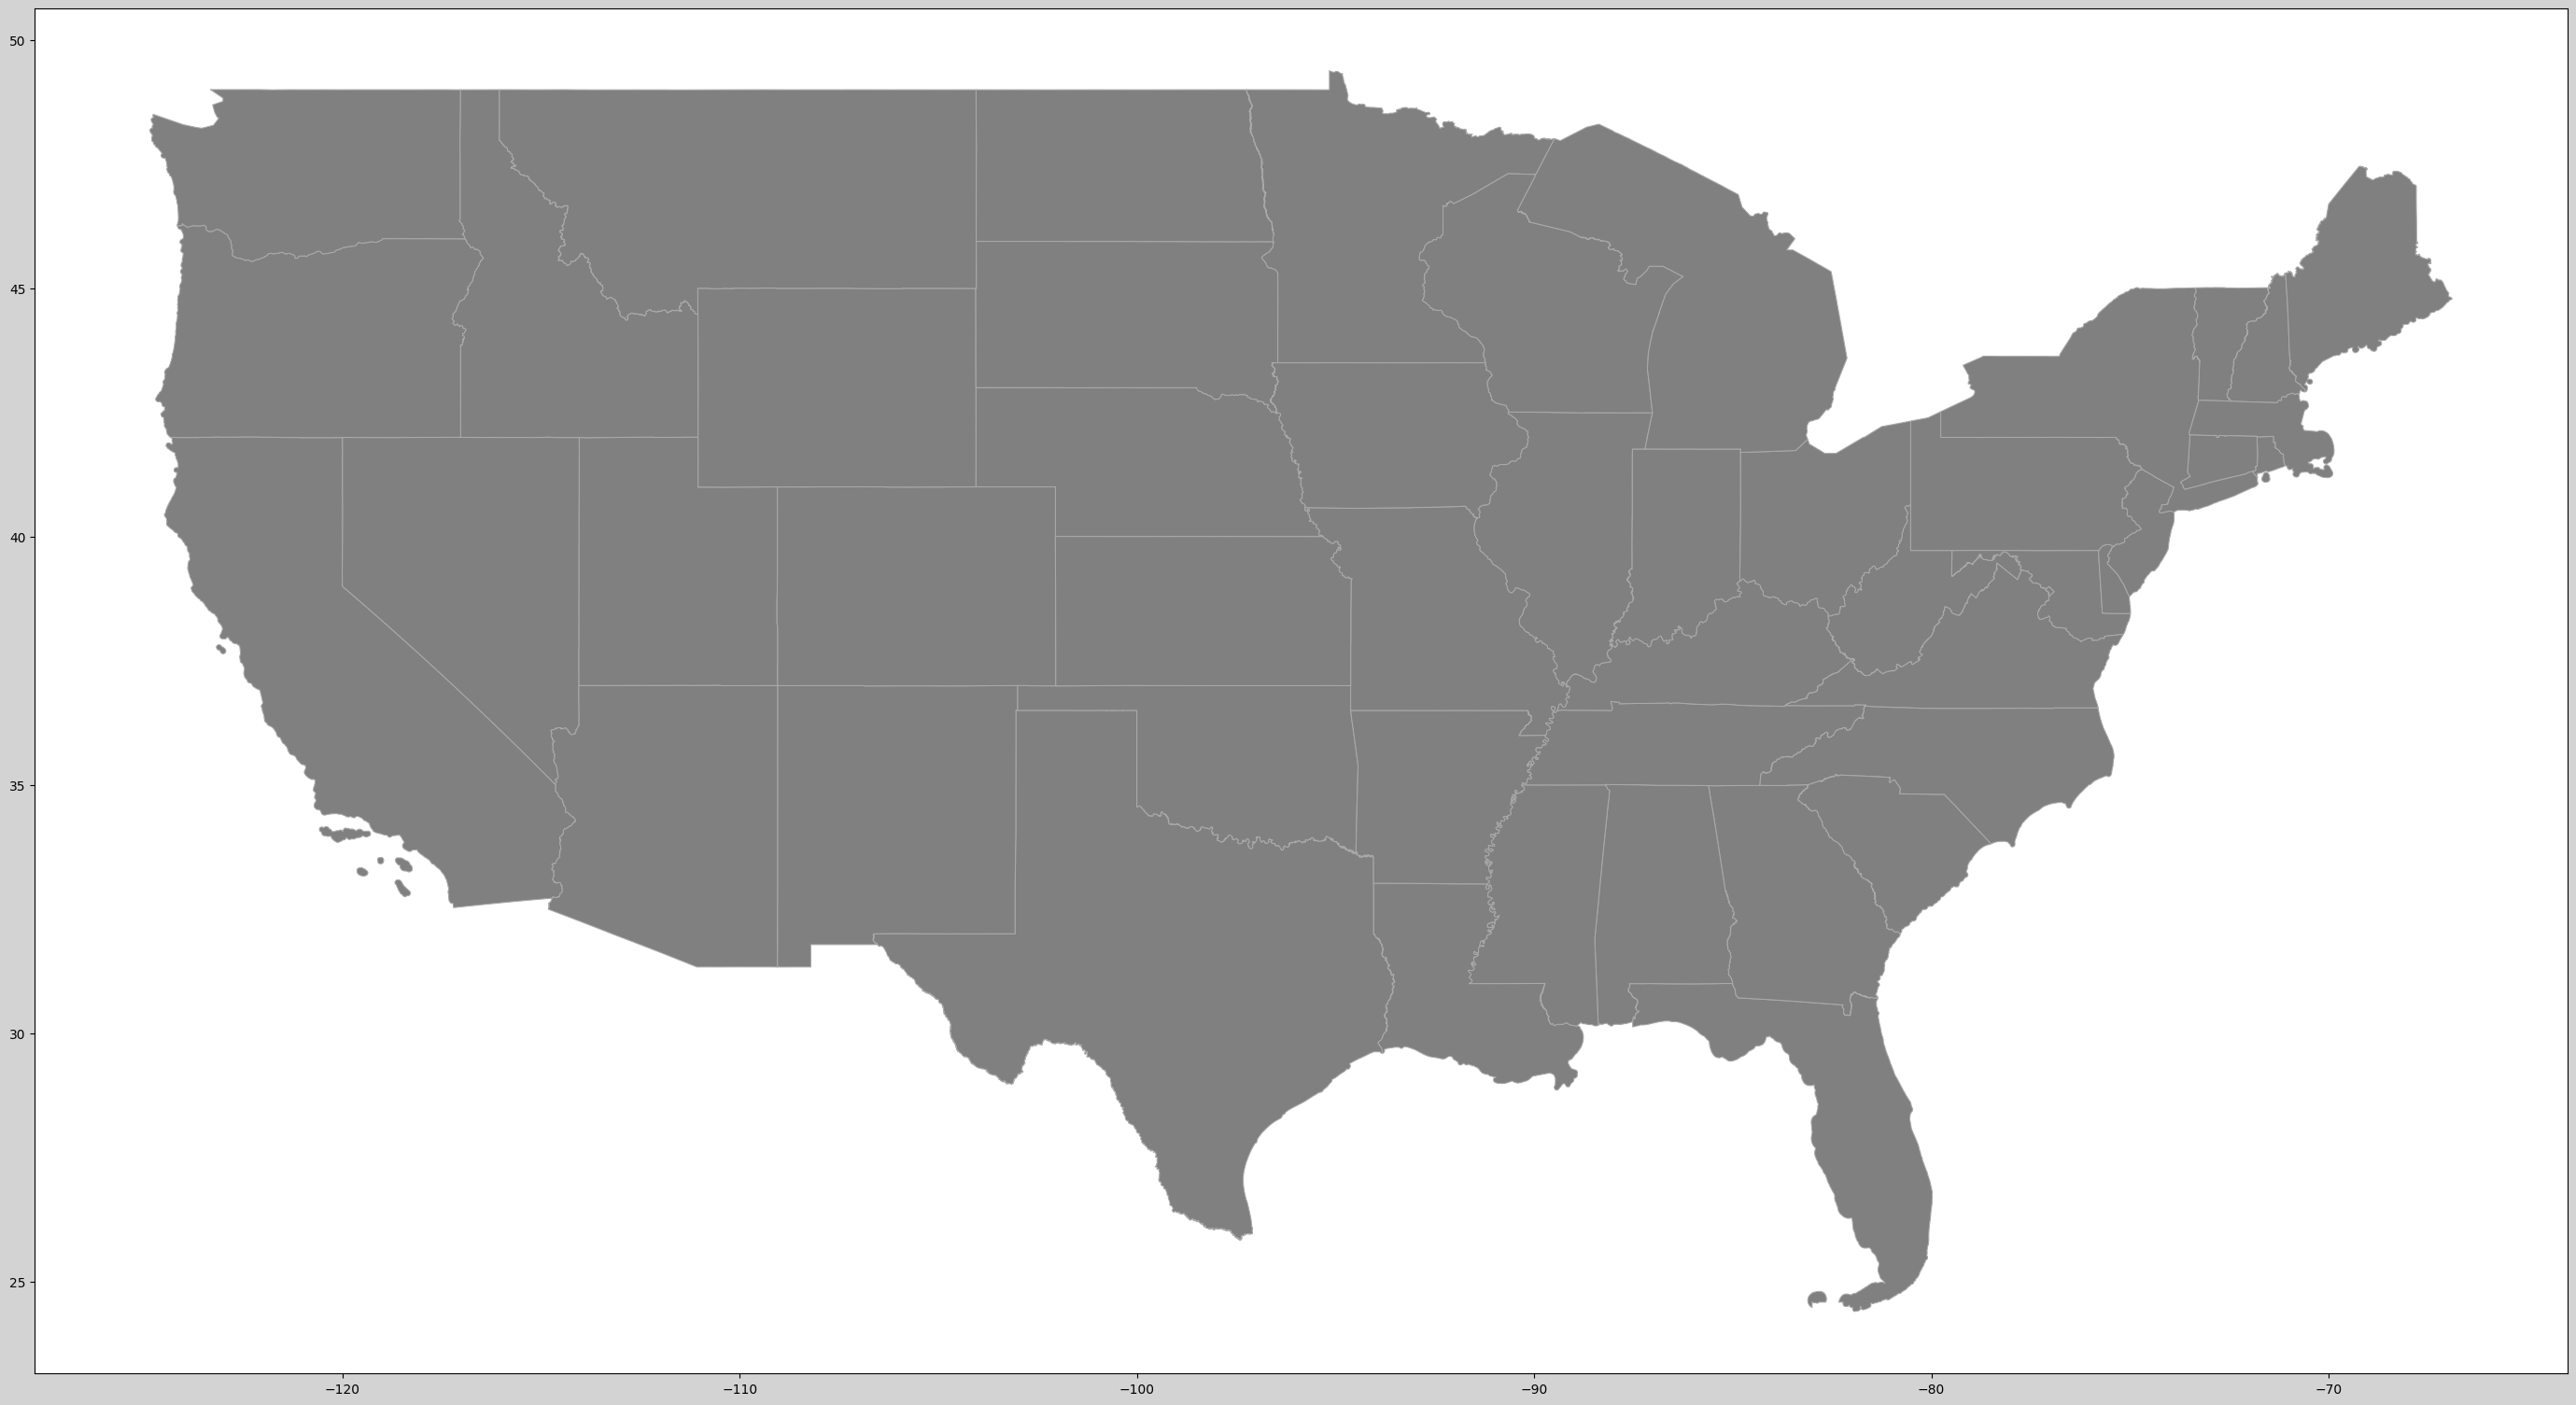

In [5]:
fig, ax = plt.subplots(figsize=(35, 35), facecolor='lightgray')
fn.plot_lower_48(ax)
#shapefile.plot(ax=ax, color='lightblue', edgecolor='black', markersize=100, linewidth=0.5, alpha=0.5)
#for x, y, label in zip(shapefile.geometry.centroid.x, shapefile.geometry.centroid.y, shapefile['aq_name']):
    #ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
plt.show()

## SCRIPT: Dataset Site Comparisons
Reports sites located in one dataset but not another

In [13]:
dataset_1 = 'Prelim_Data/_National_Metrics/OLD_National_Metrics_30_90_04152024.xlsx'
dataset_2 = 'Prelim_Data/_National_Metrics/National_Metrics_30_90.xlsx'
column = 'site_no'

df_1 = pd.read_excel(dataset_1, dtype=fn.DATASET_DTYPES)
df_2 = pd.read_excel(dataset_2, dtype=fn.DATASET_DTYPES)

In [15]:
df1_set = set(df_1[column])
df2_set = set(df_2[column])

df1_exclusive = df1_set.difference(df2_set)
df2_exclusive = df2_set.difference(df1_set)

print(f"Exclusive to Dataset 1: {len(df1_exclusive)}")
print(df1_exclusive)
print(f"Exclusive to Dataset 2: {len(df2_exclusive)}")
print(df2_exclusive)

Exclusive to Dataset 1: 4
{'03212500', '04233286', '03333700', '10265100'}
Exclusive to Dataset 2: 60
{'11455140', '022908205', '02290878', '250802081035500', '11313434', '11312676', '11313440', '11336790', '01651730', '11447830', '08042558', '02290918', '02300082', '11447890', '251549080251200', '02471019', '11313460', '08067250', '11313452', '11313431', '252230081021300', '11336600', '11455420', '11312672', '11337080', '11313240', '11336930', '252551081050900', '11313315', '07380401', '11312968', '02171700', '11337190', '01311875', '11447903', '11313433', '11304810', '01484080', '08212820', '251433080265000', '251115081075800', '08188800', '03216350', '11447905', '253047080555600', '02310743', '02290888', '11336685', '02047370', '02310740', '02050000', '11447850', '01193050', '08162501', '11313405', '06154410', '02186645', '11312685', '11311300', '12113390'}


## Script: Validity Dataset Comparison
Compare site validity numbers from the metric datasets and validity dataset to confirm all valid sites are present

In [12]:
column = 'site_no'
df_30_90 = pd.read_excel('Prelim_Data/_National_Metrics/National_Metrics_30_90.xlsx', dtype=fn.DATASET_DTYPES)
df_50_90 = pd.read_excel('Prelim_Data/_National_Metrics/National_Metrics_50_90.xlsx', dtype=fn.DATASET_DTYPES)
df_validity = pd.read_excel('Prelim_Data/_National_Validity/National_Validity.xlsx', dtype=fn.DATASET_DTYPES)

In [15]:
df_30_90_metric = df_30_90[(df_30_90['missing_data%'] <= 10) & (df_30_90['analyze_range'] >= 27)]
df_30_90_metricval = df_30_90[df_30_90['valid'] == True]
df_30_90_valid_val = df_validity[(df_validity['data_cont_30'] == True) & (df_validity['date_range_30'] == True)]

print(f'Valid 30-year Metrics: {len(df_30_90_metric)}')
print(f'Valid 30-year Metrics with Validity: {len(df_30_90_metricval)}')
print(f'Valid 30-year Metrics with Validity: {len(df_30_90_valid_val)}')

df1_set = set(df_30_90_metric[column])
df2_set = set(df_30_90_metricval[column])
df3_set = set(df_30_90_valid_val[column])

df1_exclusive = df1_set.difference(df2_set)
df2_exclusive = df2_set.difference(df1_set)
df3_exclusive = df3_set.difference(df1_set)

print(f"Exclusive to Dataset 1: {len(df1_exclusive)}")
print(df1_exclusive)
print(f"Exclusive to Dataset 2: {len(df2_exclusive)}")
print(df2_exclusive)
print(f"Exclusive to Dataset 3: {len(df3_exclusive)}")
print(df3_exclusive)

Valid 30-year Metrics: 4242
Valid 30-year Metrics with Validity: 4242
Valid 30-year Metrics with Validity: 4265
Exclusive to Dataset 1: 0
set()
Exclusive to Dataset 2: 0
set()
Exclusive to Dataset 3: 23
{'02291673', '05430500', '01401000', '08067070', '02405500', '05051500', '08057000', '05543500', '02321000', '02289041', '02312700', '254543080491101', '04191500', '04084445', '02289019', '040851385', '03333700', '254543080405401', '08386000', '02490500', '06402000', '08171300', '01102500'}


## Plot: USGS 25 Aquifer Shapefile Validation

In [19]:
shapefile = gpd.read_file('ShapeFiles/Aquifers/Conterm_US/Aquifers_USGS_25.shp')
shapefile = shapefile.dissolve(by='AQ_NAME', as_index=False)
#shapefile = shapefile.rename(columns={'AQ_NAME': 'aq_name'})
#shapefile.to_file('ShapeFiles/Aquifers/Conterm_US/master_aquifer.shp')

c:\Users\alekh\AppData\Local\Programs\Python\Python310\lib\site-packages\geopandas\plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
C:\Users\alekh\AppData\Local\Temp\ipykernel_257572\4071954358.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(shapefile.geometry.centroid.x, shapefile.geometry.centroid.y, shapefile['aq_name']):


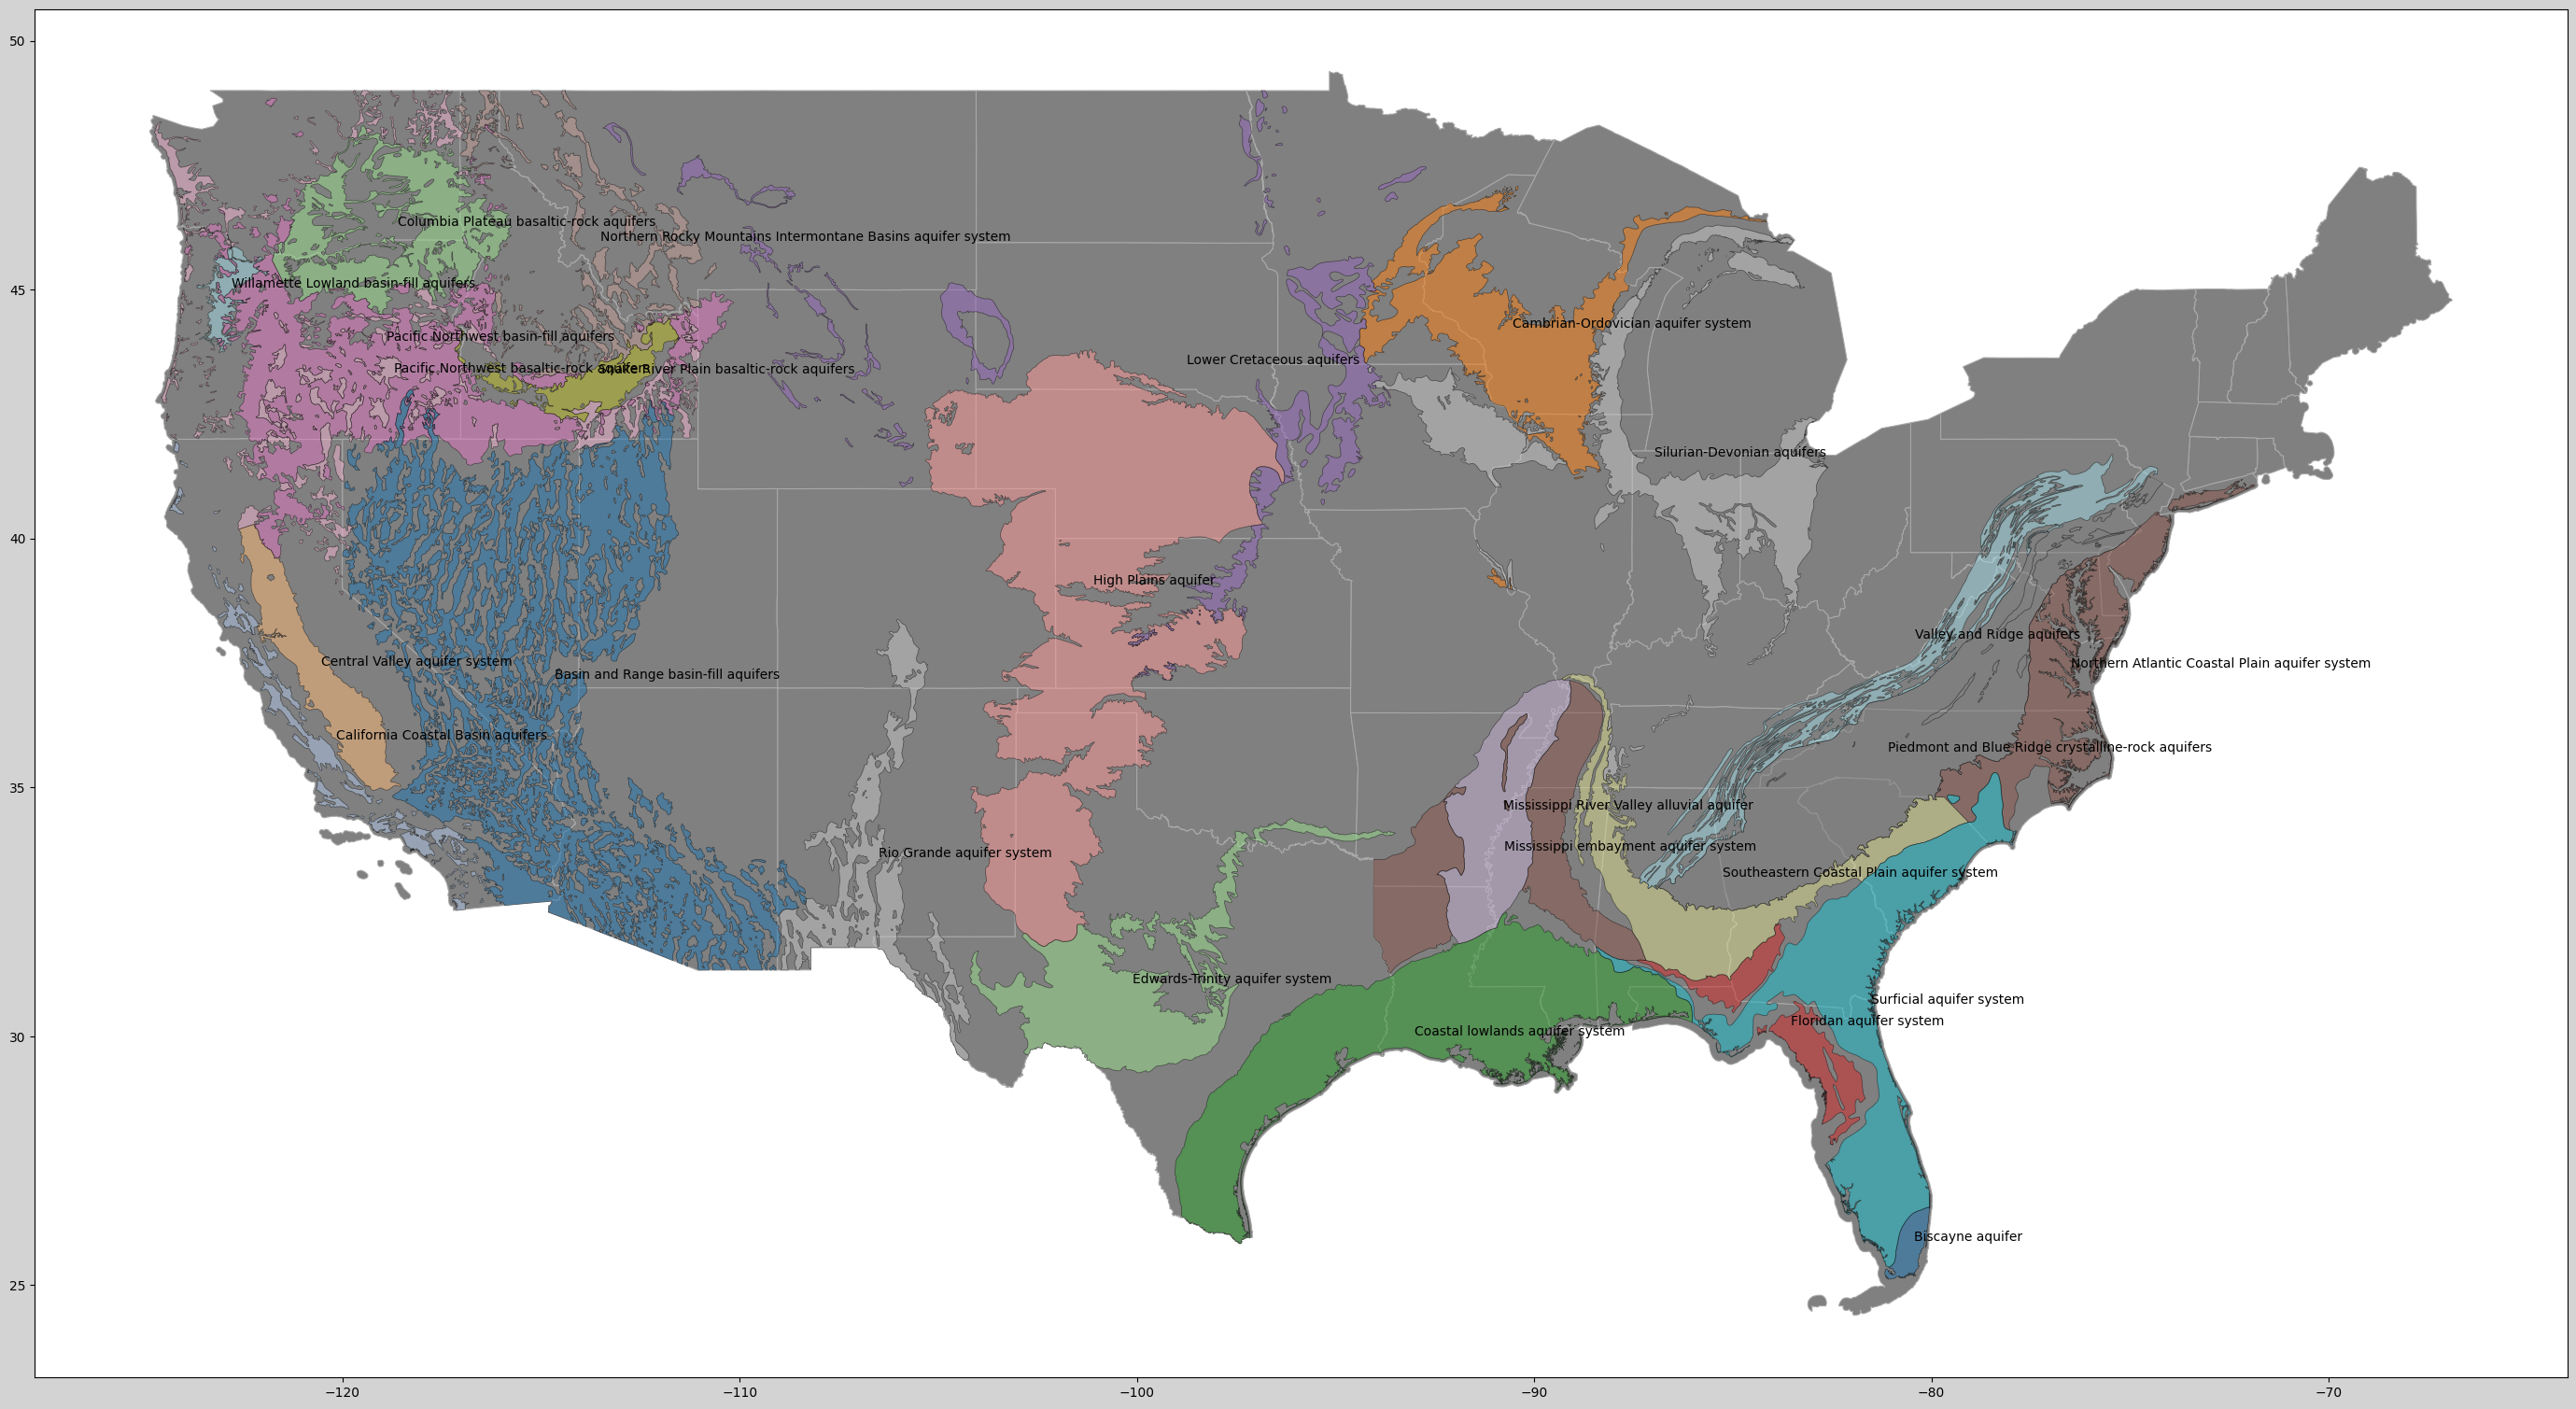

In [23]:
fig, ax = plt.subplots(figsize=(35, 35), facecolor='lightgray')
fn.plot_lower_48(ax)
shapefile.plot(ax=ax, color='lightblue', column='aq_name', cmap='tab20', edgecolor='black', markersize=100, linewidth=0.5, alpha=0.5)
for x, y, label in zip(shapefile.geometry.centroid.x, shapefile.geometry.centroid.y, shapefile['aq_name']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
plt.show()